In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# For example --->My name is shaheer
sequence_length=4
batch_size=1
input_dim=512
d_model=512
x=torch.randn((batch_size,sequence_length,input_dim))

In [11]:
x.shape

torch.Size([1, 4, 512])

In [6]:
#Multiplying it with 3 for Q,K,V
qkv_layer = nn.Linear(input_dim , 3*d_model)

In [7]:
qkv = qkv_layer(x)

In [9]:
qkv.shape

torch.Size([1, 4, 1536])

Text(0.5, 1.0, 'Distribution of QKV')

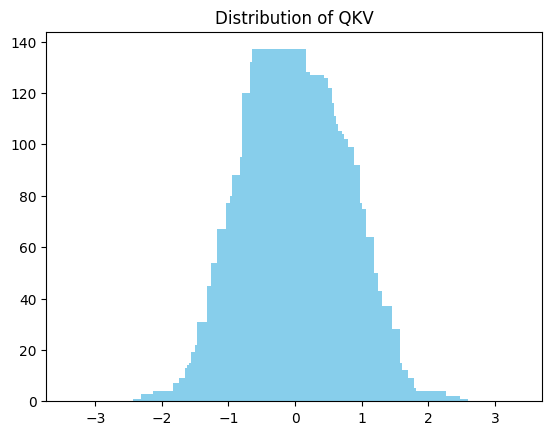

In [17]:
 import matplotlib.pyplot as plt
 y_val = torch.histc(qkv,bins=200,min=-3,max=3)
 x_val= np.arange(-1,1,0.01) *3
 plt.bar(x_val,y_val,align='center',color=['skyblue'])
 plt.title("Distribution of QKV")

In [18]:
num_head=8
head_dim = d_model // num_head
qkv = qkv.reshape(batch_size , sequence_length,num_head,3 *head_dim )

In [19]:
qkv.shape

torch.Size([1, 4, 8, 192])

In [21]:
qkv = qkv.permute(0,2,1,3)
qkv.shape

torch.Size([1, 8, 4, 192])

In [22]:
q,k,v = qkv.chunk(3,dim=-1)
q.shape,k.shape,v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

In [24]:
d_k = q.size()[-1]
d_k

64

In [26]:
import math
scaled = torch.matmul(q,k.transpose(-2,-1))/math.sqrt(d_k)
scaled.shape

torch.Size([1, 8, 4, 4])

In [27]:
k.T.shape

<ipython-input-27-879c2705464e>:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3697.)
  k.T.shape


torch.Size([64, 4, 8, 1])

In [28]:
y = torch.randn(2,3)
torch.transpose(y,0,1)

tensor([[ 0.1904,  0.9245],
        [ 0.9153, -1.4890],
        [ 0.6934,  0.2528]])

In [29]:
torch.transpose(y,1,0)

tensor([[ 0.1904,  0.9245],
        [ 0.9153, -1.4890],
        [ 0.6934,  0.2528]])

### Masking for Decoder

In [31]:
mask = torch.full(scaled.size(), float('-inf'))
mask = torch.triu(mask,diagonal=1)
mask[0][1]

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [32]:
(scaled+mask)[0][0]

tensor([[ 0.2837,    -inf,    -inf,    -inf],
        [-0.4129,  0.0606,    -inf,    -inf],
        [ 0.2186, -0.8385,  0.2408,    -inf],
        [-0.0339, -0.1048, -0.3276, -0.2316]], grad_fn=<SelectBackward0>)

In [33]:
scaled+=mask

In [34]:
attention = F.softmax(scaled , dim=-1)

In [35]:
attention.shape

torch.Size([1, 8, 4, 4])

In [36]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.3838, 0.6162, 0.0000, 0.0000],
        [0.4220, 0.1466, 0.4314, 0.0000],
        [0.2859, 0.2663, 0.2131, 0.2346]], grad_fn=<SelectBackward0>)

In [37]:
values = torch.matmul(attention , v)
values.shape

torch.Size([1, 8, 4, 64])

### Function With Mask (Decoder)

In [38]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [40]:
values, attention = scaled_dot_product(q, k, v, mask=mask)

In [41]:
attention.shape

torch.Size([1, 8, 4, 4])

In [42]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.3838, 0.6162, 0.0000, 0.0000],
        [0.4220, 0.1466, 0.4314, 0.0000],
        [0.2859, 0.2663, 0.2131, 0.2346]], grad_fn=<SelectBackward0>)

### Function without mask (Encoder)

In [43]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [46]:
values, attention = scaled_dot_product(q, k, v)

In [47]:
attention.shape

torch.Size([1, 8, 4, 4])

In [49]:
attention[0][0]

tensor([[0.3253, 0.2712, 0.2003, 0.2032],
        [0.1730, 0.2777, 0.3430, 0.2064],
        [0.2936, 0.1020, 0.3002, 0.3042],
        [0.2859, 0.2663, 0.2131, 0.2346]], grad_fn=<SelectBackward0>)

In [50]:
values.size()

torch.Size([1, 8, 4, 64])

In [52]:
values = values.reshape(batch_size, sequence_length, num_head * head_dim)
values.size()

torch.Size([1, 4, 512])

In [53]:
linear_layer = nn.Linear(d_model, d_model)

In [54]:
out = linear_layer(values)

In [55]:
out.shape

torch.Size([1, 4, 512])

#Class

In [56]:
import torch
import torch.nn as nn
import math

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, d_model, num_heads):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(input_dim , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        batch_size, sequence_length, input_dim = x.size()
        print(f"x.size(): {x.size()}")
        qkv = self.qkv_layer(x)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.permute(0, 2, 1, 3)
        print(f"qkv.size(): {qkv.size()}")
        q, k, v = qkv.chunk(3, dim=-1)
        print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}, ")
        values, attention = scaled_dot_product(q, k, v, mask)
        print(f"values.size(): {values.size()}, attention.size:{ attention.size()} ")
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        print(f"values.size(): {values.size()}")
        out = self.linear_layer(values)
        print(f"out.size(): {out.size()}")
        return out

In [57]:
input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 30
sequence_length = 5
x = torch.randn( (batch_size, sequence_length, input_dim) )

model = MultiheadAttention(input_dim, d_model, num_heads)
out = model.forward(x)

x.size(): torch.Size([30, 5, 1024])
qkv.size(): torch.Size([30, 5, 1536])
qkv.size(): torch.Size([30, 5, 8, 192])
qkv.size(): torch.Size([30, 8, 5, 192])
q size: torch.Size([30, 8, 5, 64]), k size: torch.Size([30, 8, 5, 64]), v size: torch.Size([30, 8, 5, 64]), 
values.size(): torch.Size([30, 8, 5, 64]), attention.size:torch.Size([30, 8, 5, 5]) 
values.size(): torch.Size([30, 5, 512])
out.size(): torch.Size([30, 5, 512])
